In [1]:
from IPython.display import display
from IPython.display import Image

In [2]:
from utils import * # Code shared across more than one notebook

In [3]:
output_path = "5-output_data/"

if not os.path.exists(output_path):
    os.mkdir(output_path)

# gVirtualXray vs DR

**Main contributors:** T. Wen, J. Pointon, J. Tugwell-Allsup and F. P. Vidal

**Purpose:** We aim to reporduce a real digital radiograph taken with a clinically utilised X-ray equipment.

**Material and Methods:** 

1. The CT of a chest phantom has been generated from a real scanner ahead of time. 
| Lungman phantom | 3D model of the phantom, source and detector|
|-----------------|----------|
| ![Photogram of the Lungman phantom](lungman_data/lungman.png) | ![Visualisation of the 3D model of the Lungman phantom](./3-output_data/lungman_model.png) |

2. Structures in the reference CT have been segmented and labelled. 
3. The resultant surfaces from the segmentations form a virtual lungman model. 
4. A digital radiograph was taken with a clinically utilised X-ray equipment.
5. We extract acquisition parameters from the DICOM file and initialise the X-ray simulation parameters.
6. Using a multi-objective optimisation algorithm, the virtual phantom is registered so that its simulated radiograph closely match the real digital radiograph.

**Results:** The **[zero-mean normalised cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)) is 98.92%**. 
The **[Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity) is 0.94**. The **[mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) is 1.55%**. These results show that the two images are comparable.

| Ground truth | Simulation |
|--------------|------------|
| ![digital radiograph of the anthropomorphic Lungman phantom taken with a clinically utilised X-ray equipment](3-output_data/lungman_experimental_DX_image-harder.png) | ![Corresponding image simulated using gVirtualXray](3-output_data/lungman_simulated_DX_image-harder.png) |

The calculations were performed on the following platform:

In [4]:
printSystemInfo()

OS:
	Windows 10
	AMD64

CPU:
 	AMD Ryzen 5 5600X 6-Core Processor

RAM:
	16 GB
GPU:
	Name: NVIDIA GeForce GTX 970
	Drivers: 528.02
	Video memory: 4 GB


## Import packages

In [5]:
%matplotlib inline

import os # Locate files
from time import sleep

import datetime
import math
import numpy as np # Who does not use Numpy?
import pandas as pd # Load/Write CSV files



# from scipy.stats import pearsonr # Compute the correlatio coefficient
# from skimage.util import compare_images # Checkboard comparison between two images

# from skimage.util import compare_images # Checkboard comparison between two images
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error, mean_squared_error
from skimage.metrics import normalized_mutual_information
# from sklearn.metrics.cluster import normalized_mutual_info_score
from skimage.filters import gaussian # Implementing the image sharpening filter
from sklearn.metrics.cluster import normalized_mutual_info_score


import cv2

from tifffile import imread, imwrite # Load/Write TIFF files

# import viewscad # Use OpenSCAD to create STL files

# import pyvista as pv # 3D visualisation
# from pyvista import themes

# import cma # Optimise the parameters of the noise model

# import random
import base64

# import urllib, gzip # To download the phantom data, and extract the corresponding Z file

import spekpy as sp # Generate a beam spectrum
from scipy import signal # Resampling the beam spectrum

import SimpleITK as sitk

from gvxrPython3 import gvxr # Simulate X-ray images
gvxr.useLogFile()
from gvxrPython3 import json2gvxr # Set gVirtualXRay and the simulation up
from gvxrPython3.utils import visualise

from scipy.spatial import distance # Euclidean distance

# Ignore some warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Visualisation

import matplotlib
# old_backend =  matplotlib.get_backend() 
# matplotlib.use("Agg")  # Prevent showing stuff

from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
import matplotlib.colors as mcolors

# font = {'family' : 'serif',
#         #'weight' : 'bold',
#          'size'   : 22
#        }
# matplotlib.rc('font', **font)
# matplotlib.rc('text', usetex=True)

import plotly.express as px
# import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.cmaes import CMAES


xpecgen is not install, you won't be able to load a beam spectrum using xpecgen
SimpleGVXR 2.0.3 (2023-01-13T15:03:56) [Compiler: Microsoft Visual Studio] on Windows
gVirtualXRay core library (gvxr) 2.0.3 (2023-01-13T15:03:54) [Compiler: Microsoft Visual Studio] on Windows


In [6]:
def standardisation(img):
    return (img - img.mean()) / img.std()

# Preparation of the ground truth image

## Read the real X-ray radiograph from a DICOM file

In [7]:
reader = sitk.ImageFileReader()
reader.SetImageIO("GDCMImageIO")
reader.SetFileName("lungman_data/CD3/CT000000")
reader.LoadPrivateTagsOn()
reader.ReadImageInformation()    
volume = reader.Execute()
raw_reference_before_cropping = sitk.GetArrayFromImage(volume)[0]
raw_reference_before_cropping.shape = raw_reference_before_cropping.shape

y_min_id = 25
y_max_id = raw_reference_before_cropping.shape[0] - 180
x_min_id = 100
x_max_id = raw_reference_before_cropping.shape[1] - 100

raw_reference = raw_reference_before_cropping[y_min_id:y_max_id, x_min_id:x_max_id]

print("The shape was", raw_reference_before_cropping.shape, "| now it is", raw_reference.shape)

The shape was (512, 512) | now it is (307, 312)


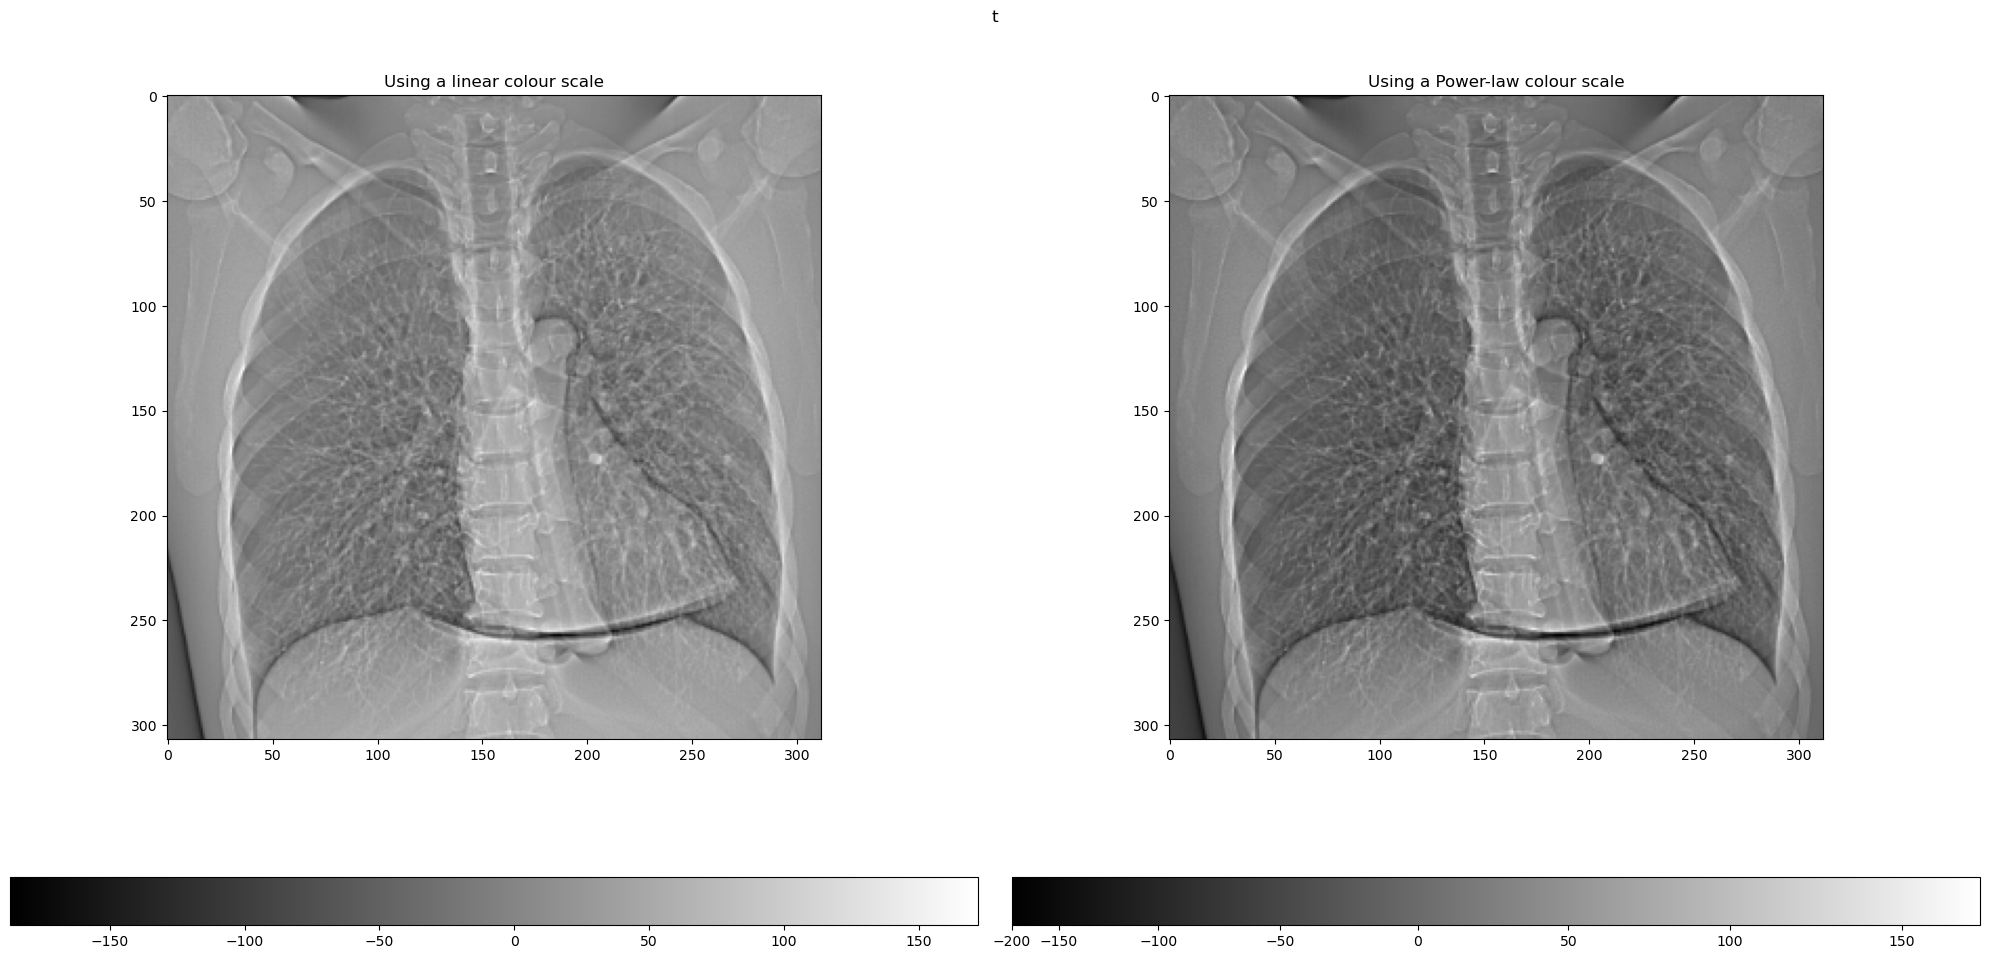

In [8]:
imwrite(output_path + '/real_projection-lungman.tif', raw_reference.astype(np.single))
displayLinearPowerScales(raw_reference, "t", "t")

We plot the image using a linear look-up table and a power-law normalisation.

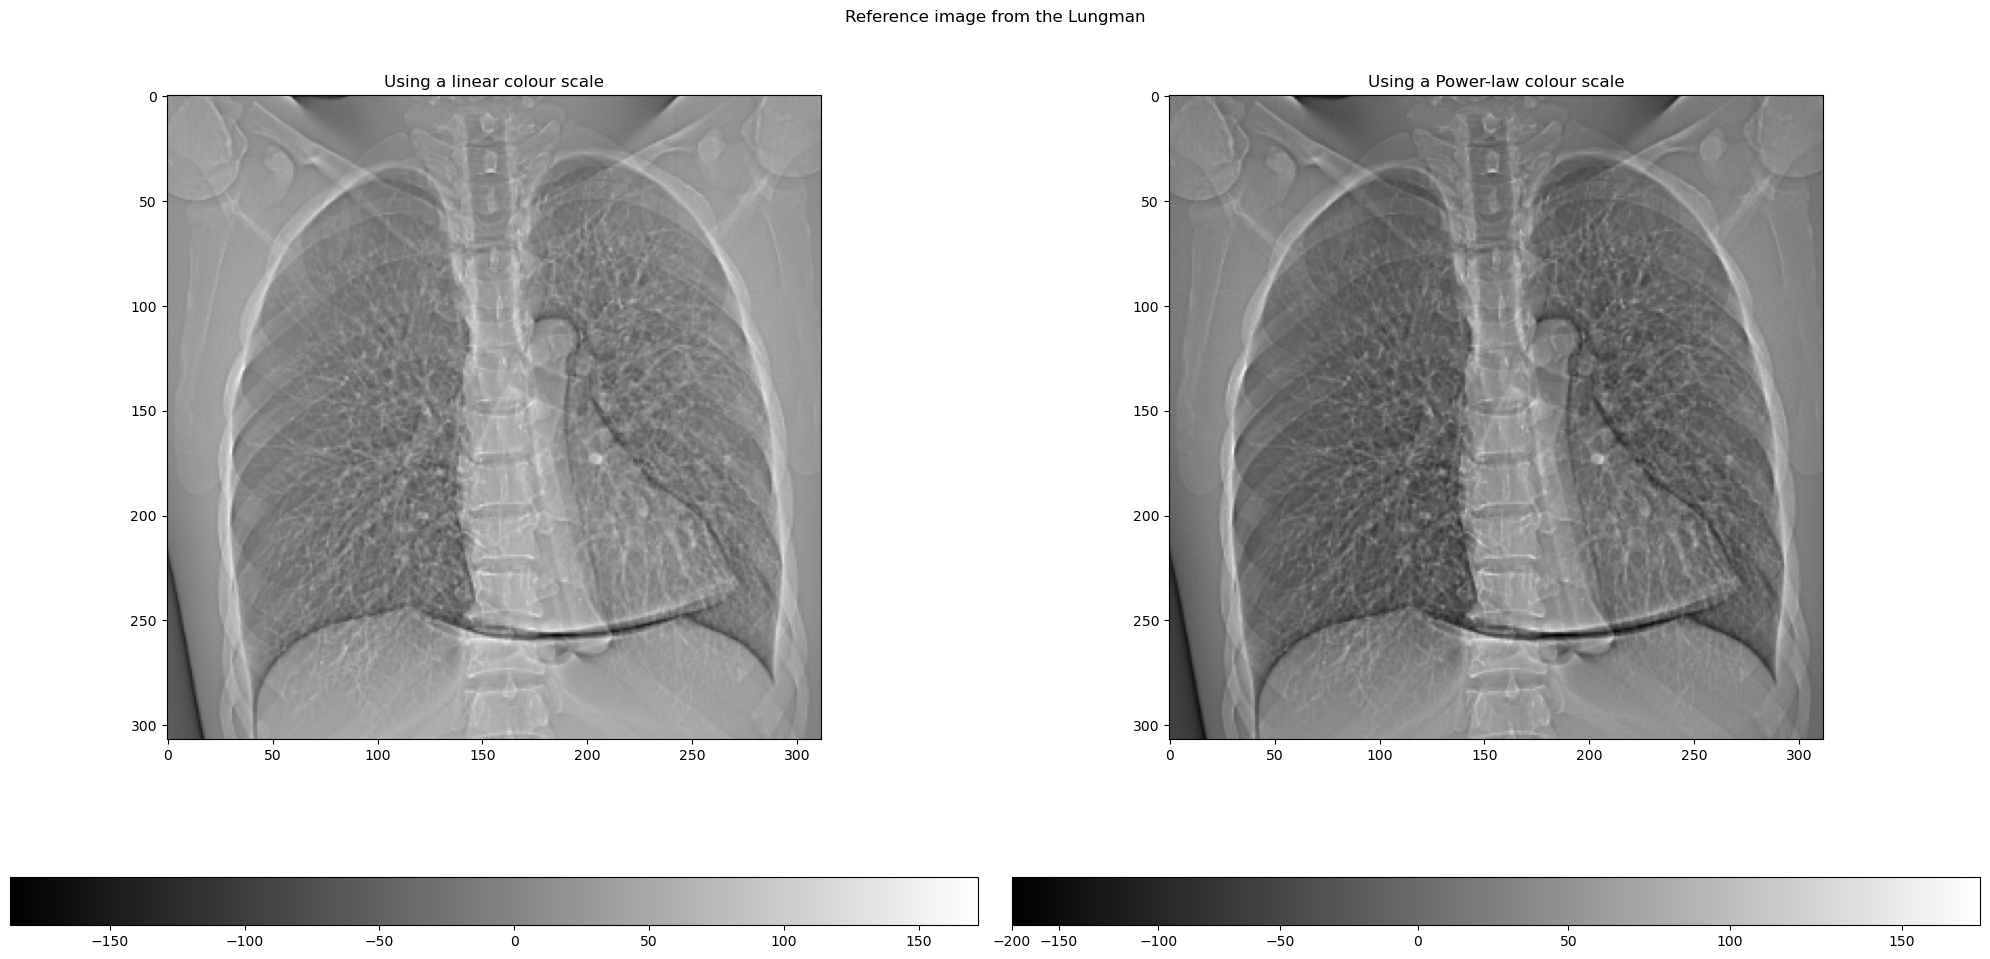

In [9]:
displayLinearPowerScales(raw_reference,
                         "Reference image from the Lungman",
                         output_path + "/reference-lungman-proj",
                         log=False,
                         vmin=-93, vmax=89)

Apply a zero-mean, unit-variance normalisation

In [10]:
ground_truth = raw_reference
normalised_ground_truth = standardisation(ground_truth)
imwrite(output_path + '/lungman-normalised_ground_truth.tif', normalised_ground_truth.astype(np.single))

## Extract the image size and pixel spacing using SimpleITK

It will be useful to set the X-ray detector parameters for the simulation, and to display the images in millimetres. We can compare these values with the ones extracted above from the DICOM attributes.

In [11]:
sitk_pixel_spacing = volume.GetSpacing()[0:2]
size = volume.GetSize()[0:2]

print("SITK Pixel Spacing (in mm): ", sitk_pixel_spacing)
print("Image size (in pixels): ", str(size[0]) + " x " + str(size[1]))

SITK Pixel Spacing (in mm):  (1.0, 1.0)
Image size (in pixels):  512 x 512


## Extract the kVp from the DICOM file

It will be useful to generate a realistic beam spectrum.

In [12]:
kVp = float(volume.GetMetaData("0018|0060"))
print("Peak kilo voltage output of the x-ray generator used: ", kVp)

Peak kilo voltage output of the x-ray generator used:  120.0


# Extract the mAs from the DICOM file

In [13]:
mAs = volume.GetMetaData("0018|1152")
print("The exposure expressed in mAs, for example calculated from Exposure Time and X-ray Tube Current:", mAs)

The exposure expressed in mAs, for example calculated from Exposure Time and X-ray Tube Current: 160 


# Extract the time of X-Ray exposure from the DICOM file

In [14]:
exposure = volume.GetMetaData("0018|1150")
print(" Time of X-Ray exposure in msec.:", exposure)

 Time of X-Ray exposure in msec.: 4573


# Extract the SID and SOD of X-Ray configuration from the DICOM file

In [15]:
distance_source_to_detector = float(volume.GetMetaData("0018|1110"))
distance_source_to_patient = float(volume.GetMetaData("0018|1111"))

print("Distance Source to Detector: ", distance_source_to_detector, "mm")
print("Distance Source to Patient: ", distance_source_to_patient, "mm")


Distance Source to Detector:  1085.6 mm
Distance Source to Patient:  595.0 mm


# Extract information about the "sizes" of pixels from the DICOM file

The descriptions have been extracted from [https://dicom.innolitics.com](https://dicom.innolitics.com)

## Imager Pixel Spacing Attribute

Physical distance measured at the front plane of the Image Receptor housing between the center of each pixel. Specified by a numeric pair - row spacing value (delimiter) column spacing value - in mm.

In the case of CR, the front plane is defined to be the external surface of the CR plate closest to the patient and radiation source.

## Detector Element Physical Size Attribute

Physical dimensions of each detector element that comprises the detector matrix, in mm.

Expressed as row dimension followed by column.

**Note:**

This may not be the same as Detector Element Spacing (0018,7022) due to the presence of spacing material between detector elements.

## Detector Element Spacing Attribute

Physical distance between the center of each detector element, specified by a numeric pair - row spacing value(delimiter) column spacing value in mm. See Section 10.7.1.3 for further explanation of the value order.

**Note:**

This may not be the same as the Imager Pixel Spacing (0018,1164), and should not be assumed to describe the stored image.

In [16]:

magnification = distance_source_to_detector / distance_source_to_patient;
print("Magnification:", magnification)

imager_pixel_spacing = np.array([magnification, magnification])
detector_element_physical_size = np.array([magnification, magnification])
detector_element_spacing = np.array([magnification, magnification])

Magnification: 1.8245378151260503


# Initialise gVirtualXRay

## Set the experimental parameters (e.g. source and detector positions, etc.)

We use known parameters as much as possible, for example we know the size and composition of the sample. Some parameters are extracted from the DICOM file, such as detector size, pixel resolution, and voltage of the X-ray tube.

In [17]:

window_size =  [800, 450]
# source_position = [0.0, 0.0, source_detector_distance_in_cm - block_thickness_in_cm / 2, "mm"]
# detector_position = [0.0, 0.0, - block_thickness_in_cm / 2, "cm"]
detector_up = [0, 1, 0]

## Initialise the simulation engine

In [18]:
# Create an OpenGL context
print("Create an OpenGL context:",
    str(window_size[0]) + "x" + str(window_size[1])
)

gvxr.createWindow(-1, True, "OPENGL")

gvxr.setWindowSize(
    window_size[0],
    window_size[1]
)

Create an OpenGL context: 800x450


## Load the scanned object

In [19]:
json2gvxr.initSamples("notebook-5.json", verbose=0)

In [20]:
number_of_triangles = 0

for sample in json2gvxr.params["Samples"]:
    label = sample["Label"]
    number_of_triangles_in_mesh = gvxr.getNumberOfPrimitives(label)
    number_of_triangles += number_of_triangles_in_mesh

In [21]:
skin_bbox = gvxr.getNodeOnlyBoundingBox("Skin", "mm")
print(skin_bbox)

(-159.375, -117.5, -148.40000915527344, 159.375, 107.5, 148.40000915527344)


## Set the source position

In [22]:
# Set up the beam
print("Set up the beam")
print("\tSource position:", (skin_bbox[0] + skin_bbox[3]) / 2, distance_source_to_patient, (skin_bbox[2] + skin_bbox[5]) / 2, "mm")

gvxr.setSourcePosition((skin_bbox[0] + skin_bbox[3]) / 2, distance_source_to_patient, (skin_bbox[2] + skin_bbox[5]) / 2, "mm")

gvxr.usePointSource()

Set up the beam
	Source position: 0.0 477.5 0.0 mm


## Get the spectrum from the DICOM file

In [23]:
spectrum = {};
# filter_material = "Al"      # See email Mon 05/07/2021 15:29
# filter_thickness_in_mm = 3  # See email Mon 05/07/2021 15:29

s = sp.Spek(kvp=kVp)
# s.filter(filter_material, filter_thickness_in_mm) # Filter by 3 mm of Al
unit = "keV"
k, f = s.get_spectrum(edges=True) # Get the spectrum

min_energy = sys.float_info.max
max_energy = -sys.float_info.max

for energy, count in zip(k, f):
    count = round(count)

    if count > 0:

        max_energy = max(max_energy, energy)
        min_energy = min(min_energy, energy)

        if energy in spectrum.keys():
            spectrum[energy] += count
        else:
            spectrum[energy] = count

Reformat the data

In [24]:
# get the integral nb of photons
nbphotons=0.
energy1 = -1.
energy2 = -1.

for energy in spectrum.keys():
    
    if energy1<0:
        energy1 = float(energy)
    elif energy2<0:
        energy2 = float(energy)
    nbphotons += float(spectrum[energy])
sampling = (energy2-energy1)

# get spectrum
data = []
for energy in spectrum.keys():
    source = [float(energy),float(spectrum[energy])/(nbphotons*sampling)]
    data.append(source)

data_array = np.array(data)

energies, counts = data_array.T

Resample the data to reduce the number of bins

In [25]:
temp_count_set = signal.decimate(counts, 6)
number_of_energy_bins = temp_count_set.shape[0]
temp_energy_set = np.linspace(energies.min(), energies.max(), number_of_energy_bins, endpoint=True)

test = temp_count_set > 0
count_set = temp_count_set[test]
energy_set = temp_energy_set[test]

Plot the beam spectrum from spekpy and the resampled vervion

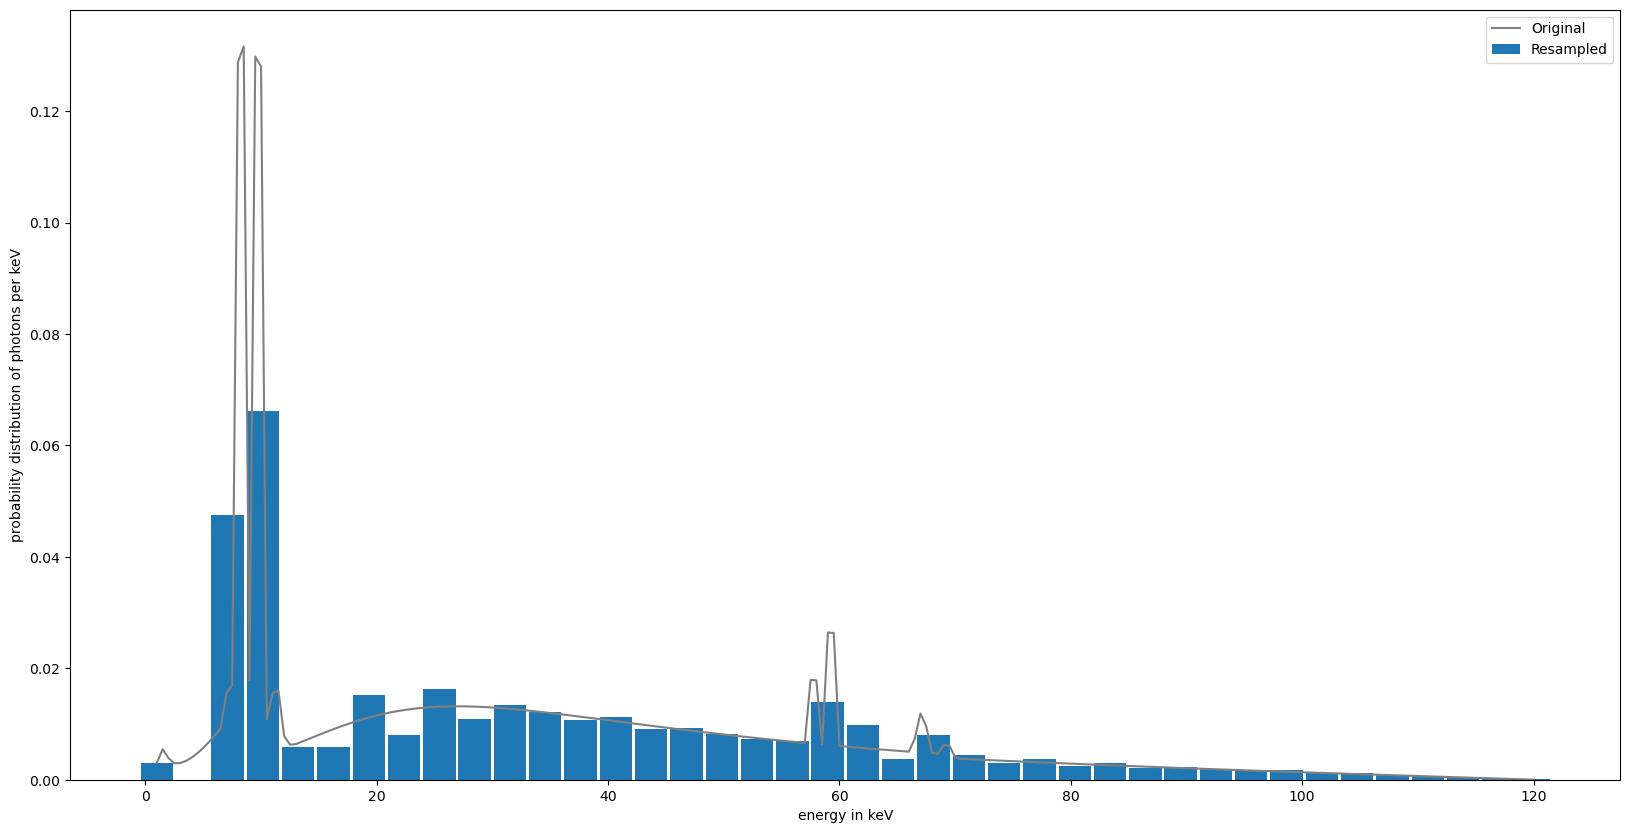

In [26]:
plt.figure(figsize= (20,10))
plt.bar(energy_set, count_set, width=2.8, label="Resampled")
plt.plot(energies, counts, label="Original", color="gray")
plt.xlabel('energy in keV')
plt.ylabel('probability distribution of photons per keV')
plt.legend()
plt.savefig(output_path + "/lungman-projection-spectrum.pdf")

## Load the beam spectrum in the simulator

In [27]:
gvxr.resetBeamSpectrum() # To be on the safe side when debugging
for energy, count in zip(energy_set, count_set):
    gvxr.addEnergyBinToSpectrum(energy, unit, count);

## Set the X-ray detector

In [28]:
# Set up the detector
print("Set up the detector");
print("\tDetector position:", (skin_bbox[0] + skin_bbox[3]) / 2, distance_source_to_patient - distance_source_to_detector, (skin_bbox[2] + skin_bbox[5]) / 2, "mm")
gvxr.setDetectorPosition((skin_bbox[0] + skin_bbox[3]) / 2, distance_source_to_patient - distance_source_to_detector, (skin_bbox[2] + skin_bbox[5]) / 2, "mm");

print("\tDetector up vector:", [0, 0, 1])
gvxr.setDetectorUpVector(0, 0, 1);

Set up the detector
	Detector position: 0.0 -490.5999999999999 0.0 mm
	Detector up vector: [0, 0, 1]


In [29]:
print("\tDetector number of pixels:", size)
gvxr.setDetectorNumberOfPixels(
    size[0],
    size[1]
);

print("\tPixel spacing:", imager_pixel_spacing)
gvxr.setDetectorPixelSize(
    imager_pixel_spacing[0],
    imager_pixel_spacing[1],
    "mm"
);

	Detector number of pixels: (512, 512)
	Pixel spacing: [1.82453782 1.82453782]


Load the detector response in energy

In [30]:
gvxr.clearDetectorEnergyResponse() # To be on the safe side
gvxr.loadDetectorEnergyResponse("Gate_data/responseDetector.txt",
                                "MeV")


## Take a screenshot of the 3D environment

In [31]:
gvxr.displayScene()

gvxr.useNegative()
gvxr.useLighing()
gvxr.useWireframe()
gvxr.setSceneRotationMatrix([0.43813619017601013, 0.09238918125629425, -0.8941444158554077, 0.0,
                             0.06627026945352554, 0.9886708855628967, 0.13463231921195984, 0.0,
                             0.8964602947235107, -0.11824299395084381, 0.4270564019680023, 0.0,
                             0.0, 0.0, 0.0, 1.0])
gvxr.setZoom(2639.6787109375)

gvxr.displayScene()

In [32]:
screenshot = gvxr.takeScreenshot()

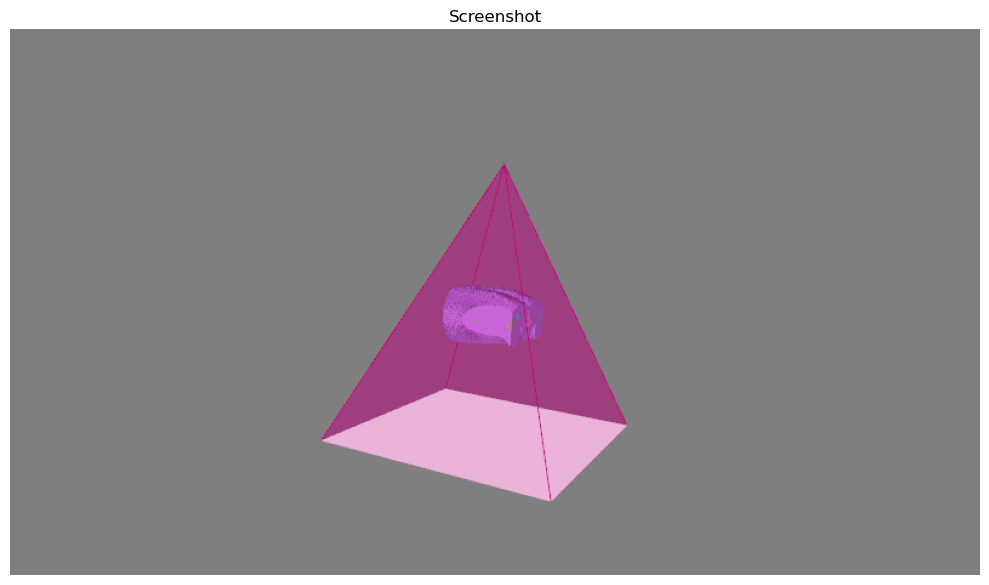

In [33]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig(output_path + '/lungman-projection-screenshot-beam-off.pdf')
plt.savefig(output_path + '/lungman-projection-screenshot-beam-off.png')

In [34]:
gvxr.computeXRayImage()
gvxr.displayScene()

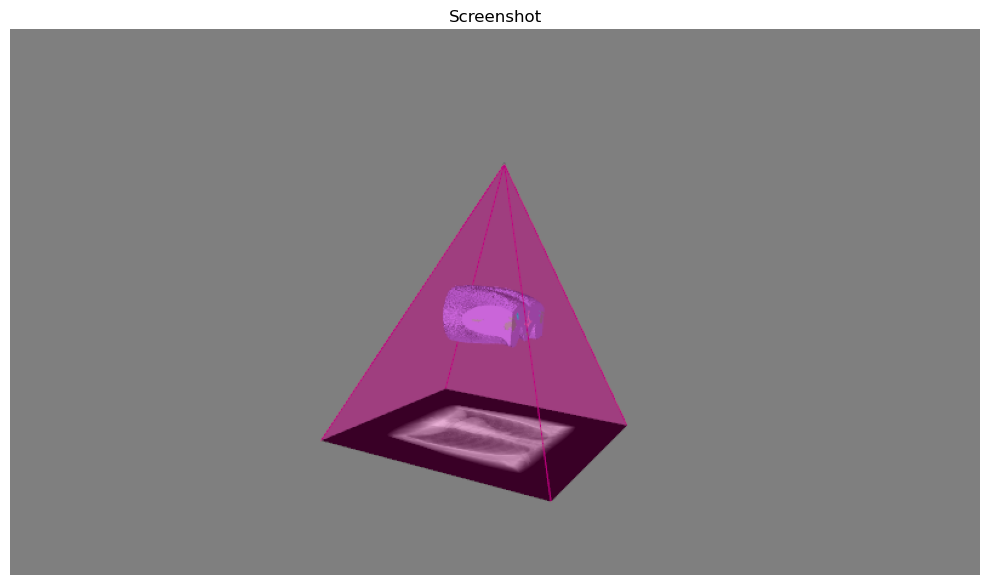

In [35]:
screenshot = gvxr.takeScreenshot()

plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig(output_path + '/lungman-projection-screenshot-beam-on.pdf')
plt.savefig(output_path + '/lungman-projection-screenshot-beam-on.png')

## Simulation with the default values

In [36]:
# Backup the transformation matrix
global_matrix_backup = gvxr.getSceneTransformationMatrix()

In [37]:
def getXRayImage():
    global total_energy_in_MeV

    # Compute the X-ray image
    xray_image = np.array(gvxr.computeXRayImage())
        
    # Flat-field
#     xray_image /= total_energy_in_MeV
    
    # Negative
    # x_ray_image = 1.0 - x_ray_image
    return np.flip(xray_image) #np.ones(xray_image.shape).astype(np.single) - xray_image

In [38]:
# gvxr.enableArtefactFilteringOnCPU()
gvxr.enableArtefactFilteringOnGPU()
# gvxr.disableArtefactFiltering() # Spere inserts are missing with GPU integration when a outer surface is used for the matrix

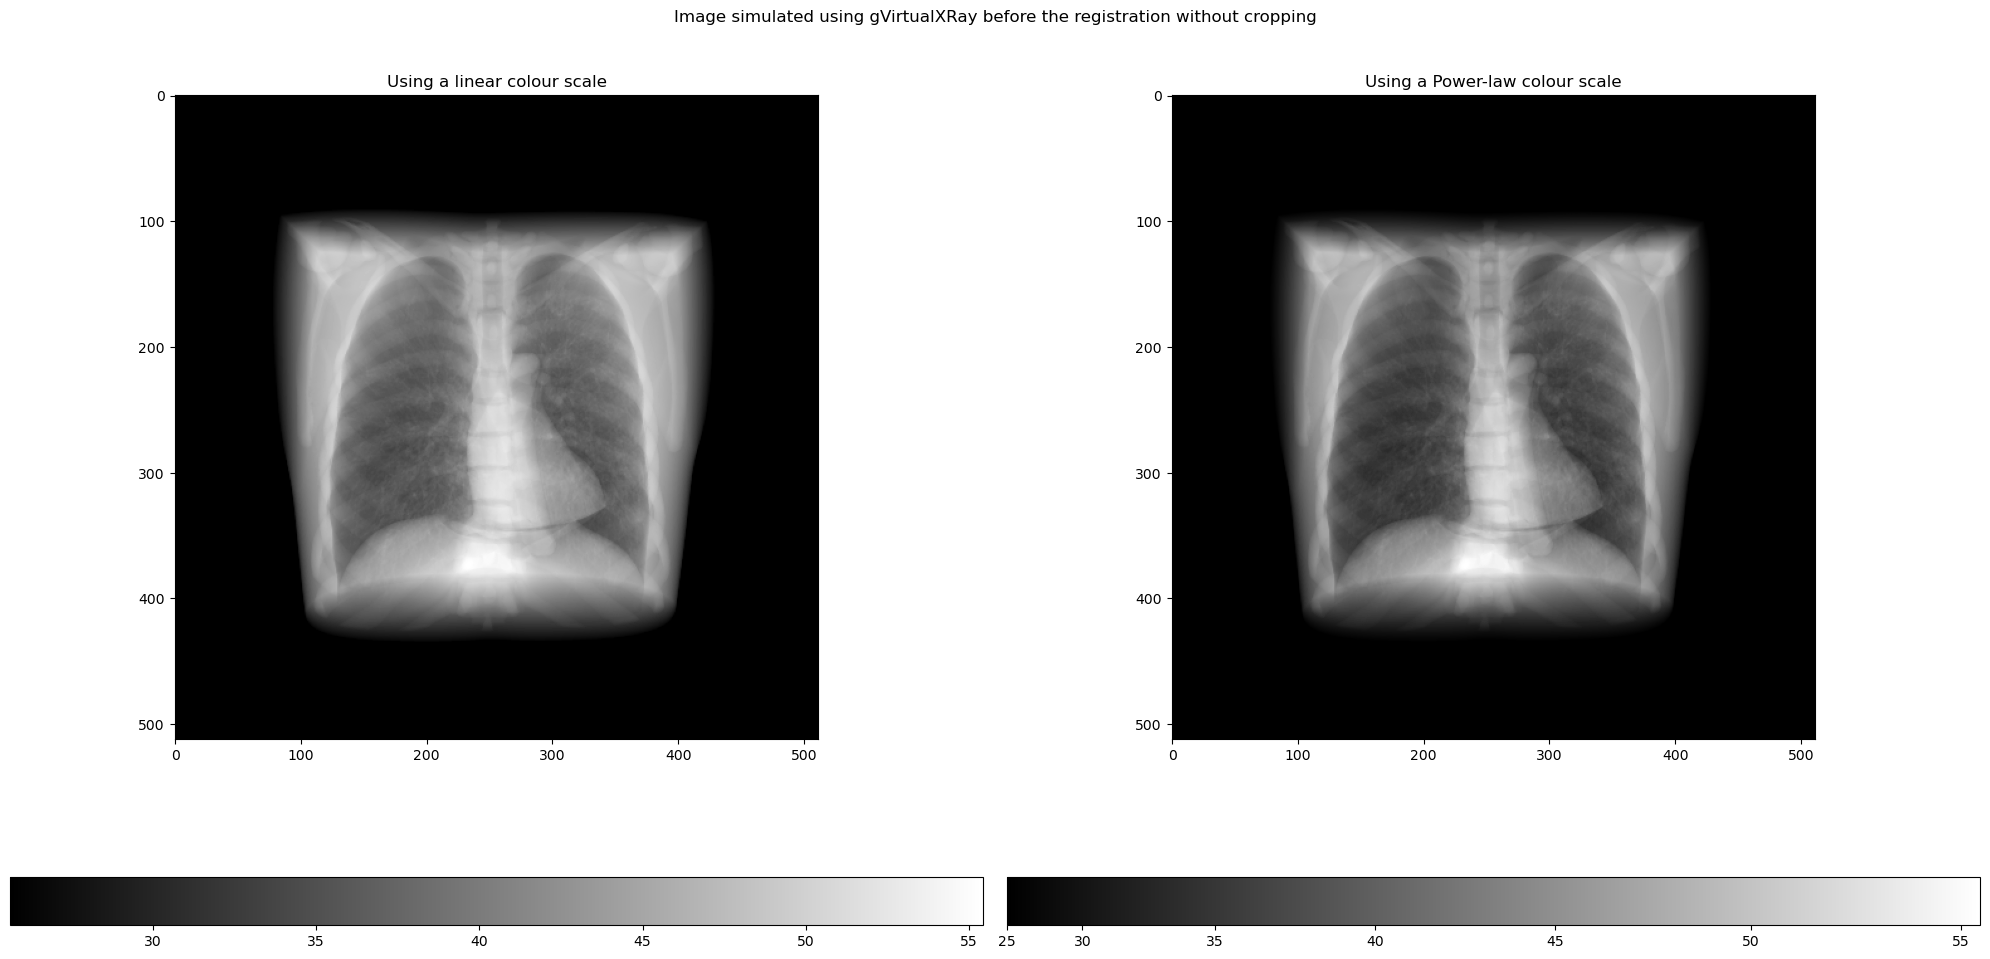

In [39]:
xray_image = getXRayImage()
#imwrite(output_path + '/initial-projection.tif', minusLog(xray_image.astype(np.single)))
displayLinearPowerScales(minusLog(xray_image.astype(np.single)), "Image simulated using gVirtualXRay before the registration without cropping",
                         output_path + "/gVirtualXRay-before_registration-crop-lungman")

In [40]:
# total_energy_in_keV = 0.0
# for energy, count in zip(energy_set, count_set):
#     effective_energy = find_nearest(detector_response[:,0], energy / 1000, detector_response[:,1])

#     total_energy_in_keV += effective_energy * count
    
total_energy_in_MeV = gvxr.getTotalEnergyWithDetectorResponse()

In [41]:
gvxr.displayScene()
gvxr.useNegative()

gvxr.setZoom(1339.6787109375)
gvxr.setSceneRotationMatrix([0.8227577805519104, 0.1368587613105774, -0.5516625642776489, 0.0, -0.5680444240570068, 0.23148967325687408, -0.7897683382034302, 0.0, 0.01961756870150566, 0.9631487131118774, 0.26820749044418335, 0.0, 0.0, 0.0, 0.0, 1.0])

gvxr.setWindowBackGroundColour(0.5, 0.5, 0.5)

gvxr.displayScene()

In [42]:
# gvxr.renderLoop()

In [43]:
# print(gvxr.getZoom())
# print(gvxr.getSceneRotationMatrix())

In [44]:
screenshot = (255 * np.array(gvxr.takeScreenshot())).astype(np.uint8)

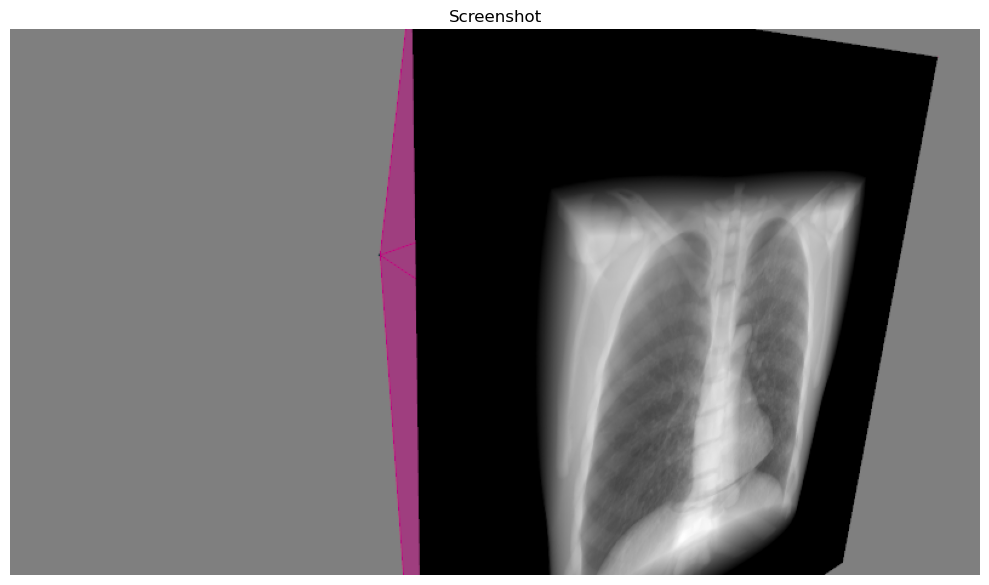

In [45]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig(output_path + '/default-screenshot-beam-on-lungman.pdf')
plt.savefig(output_path + '/default-screenshot-beam-on-lungman.png')

In [46]:
def logImage(xray_image: np.array, min_val: float, max_val: float) -> np.array:
    
    log_epsilon = 1.0e-9

    shift_filter = -math.log(min_val + log_epsilon)
    
    if min_val != max_val:
        scale_filter = 1.0 / (math.log(max_val + log_epsilon) - math.log(min_val + log_epsilon))
    else:
        scale_filter = 1.0

    corrected_image = np.log(xray_image + log_epsilon)

    return (corrected_image + shift_filter) * scale_filter

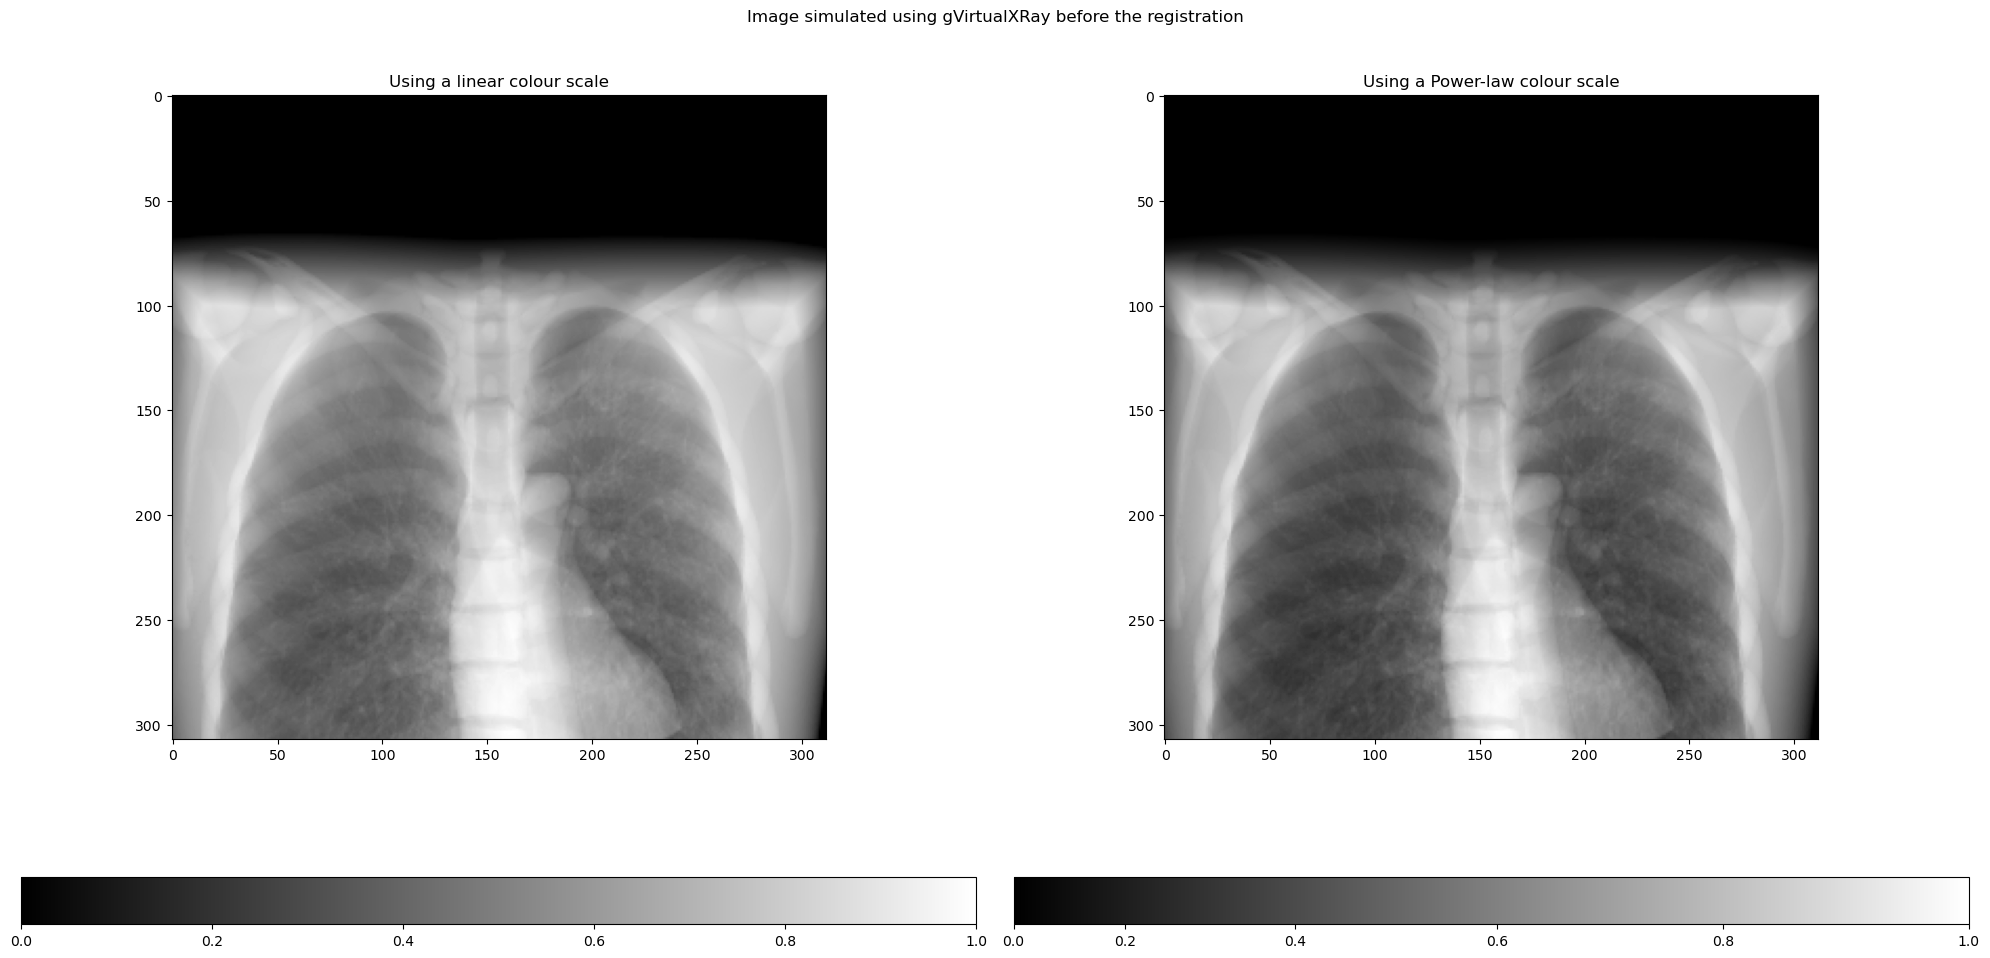

In [47]:
xray_image_cropped = xray_image[y_min_id:y_max_id, x_min_id:x_max_id]
displayLinearPowerScales(1 - logImage(xray_image_cropped, xray_image_cropped.min(), xray_image_cropped.max()),
                         "Image simulated using gVirtualXRay before the registration",
                         output_path + "/gVirtualXRay-before_registration-lungman",
                         log=False)

## Registration

In [48]:
roi_ground_truth_min = ground_truth.min()
roi_ground_truth_max = ground_truth.max()
standardised_roi_ground_truth = standardisation(ground_truth)



imwrite(output_path + '/standardised_roi_ground_truth-lungman.tif', standardised_roi_ground_truth.astype(np.single))

#### Keep a backup of the original source and detector position for registration

In [49]:
source_position_bak = gvxr.getSourcePosition("cm")
detector_position_bak = gvxr.getDetectorPosition("cm")


x_init = [
    # Orientation of the sample
    0.0, 0.0, 0.0,

    # Position of the source
    source_position_bak[0],
    source_position_bak[1],
    source_position_bak[2],

    # Position of the detector
    detector_position_bak[0],
    detector_position_bak[1],
    detector_position_bak[2]#,

    # Orientation of the detector
    #     det_rotation_angle1 = x[8]
    #     det_rotation_angle2 = x[9]

#         1.0 / 3.0, # c1
#         1.0, # gain1
#         0.0, # bias1

#         1.0 / 3.0, # c2
#         1.0, # gain2
#         0.0#, # bias2

#         1.0 / 3.0, # c3
#         1.0, # gain3
#         0.0, # bias3
#         2.0 # gamma
]


pos_offset = 30
angle_offset = 10

xl = [
            -angle_offset, -angle_offset, -angle_offset, 
            source_position_bak[0] - pos_offset, source_position_bak[1] - pos_offset, source_position_bak[2] - pos_offset,
            detector_position_bak[0] - pos_offset, detector_position_bak[1] - pos_offset, detector_position_bak[2] - pos_offset#,
#             -90, -90, 
#             -10.0,
#             -10.0,
#             -10.0,

#             -10.0,
#             0.0,
#             0.0#,

#             -10.0,
#             -10.0,
#             -10.0,
#             0.0
        ]

xu = [
            angle_offset, angle_offset, angle_offset, 
            source_position_bak[0] + pos_offset, source_position_bak[1] + pos_offset, source_position_bak[2] + pos_offset,
            detector_position_bak[0] + pos_offset, detector_position_bak[1] + pos_offset, detector_position_bak[2] + pos_offset #,
#             90, 90, 
#             10.0,
#             10.0,
#             10.0,

#             10.0,
#             10.0,
#             10.0#,

#             10.0,
#             10.0,
#             10.0,
#             100.0
        ]
        
def resetToDefaultParameters():
    gvxr.setSourcePosition(source_position_bak[0], source_position_bak[1], source_position_bak[2], "cm")
    gvxr.setDetectorPosition(detector_position_bak[0], detector_position_bak[1], detector_position_bak[2], "cm")


    # Restore the transformation matrix
    gvxr.setSceneTransformationMatrix(global_matrix_backup)


In [50]:
def setTransformations(x):
    # Orientation of the sample
    sample_rotation_angle1 = x[0]
    sample_rotation_angle2 = x[1]
    sample_rotation_angle3 = x[2]

    gvxr.rotateScene(sample_rotation_angle1, 1, 0, 0)
    gvxr.rotateScene(sample_rotation_angle2, 0, 1, 0)
    gvxr.rotateScene(sample_rotation_angle3, 0, 0, 1)

    # Position of the source
    source_position_x = x[3]
    source_position_y = x[4]
    source_position_z = x[5]
    
    gvxr.setSourcePosition(
        source_position_x,
        source_position_y,
        source_position_z,
        "cm"
    )
    
    # Position of the detector
    det_position_x = x[6]
    det_position_y = x[7]
    det_position_z = x[8]
    
    gvxr.setDetectorPosition(
        det_position_x,
        det_position_y,
        det_position_z,
        "cm"
    )

    # Orientation of the detector
#     det_rotation_angle1 = x[8]
#     det_rotation_angle2 = x[9]   

In [51]:
def updateXRayImage(x, restore_transformation=True):
    
    
    # Backup the transformation matrix
    if restore_transformation:
        matrix_backup = gvxr.getSceneTransformationMatrix()

    # Set the transformations
    setTransformations(x)

    # Compute the X-ray image
    xray_image = getXRayImage()

#     gvxr.displayScene()
#     screenshot = gvxr.takeScreenshot()

    # Restore the transformation matrix
    if restore_transformation:
        gvxr.setSceneTransformationMatrix(matrix_backup)

    return xray_image #, screenshot

In [52]:
def applyLogScaleAndNegative(image: np.array) -> np.array:
    temp = logImage(image, image.min(), image.max())
    return 1.0 - temp

# Refine the results with CMA-ES

In [53]:
def objectiveFunctionGeometry(x):
    
    global objective_function_string
    
    global ground_truth, standardised_roi_ground_truth
    global best_fitness, best_fitness_id, fitness_function_call_id, evolution_fitness, evolution_parameters

    objectives = []
    
    for ind in x:
        xray_image = updateXRayImage(ind)
        corrected_xray_image = applyLogScaleAndNegative(xray_image[y_min_id:y_max_id, x_min_id:x_max_id])
        corrected_xray_image = corrected_xray_image.astype(np.single)

        if corrected_xray_image.min() != corrected_xray_image.max():
            standardised_corrected_xray_image = standardisation(corrected_xray_image)
        else:
            standardised_corrected_xray_image = corrected_xray_image
            
        # gX = cv2.Sobel(corrected_xray_image, ddepth=cv2.CV_32F, dx=1, dy=0)
        # gY = cv2.Sobel(corrected_xray_image, ddepth=cv2.CV_32F, dx=0, dy=1)
        # gX = cv2.convertScaleAbs(gX)
        # gY = cv2.convertScaleAbs(gY)
        # test_grad_magn = cv2.addWeighted(gX, 0.5, gY, 0.5, 0)
        
        
        ref_image = standardised_roi_ground_truth
        test_image = standardised_corrected_xray_image
        
        # ref_image = ref_grad_magn
        # if test_grad_magn.min() != test_grad_magn.max():
        #     test_grad_magn = standardisation(test_grad_magn)
        # else:
        #     test_image = test_grad_magn
                
        zncc = np.mean(standardised_roi_ground_truth * standardised_corrected_xray_image)
        dzncc = (1.0 - zncc) / 2.0
        objective = dzncc

#         mae = np.mean(np.abs(standardised_roi_ground_truth - standardised_corrected_xray_image))
#         objective = mae

        #rmse = math.sqrt(np.mean(np.square(standardised_roi_ground_truth - standardised_corrected_xray_image)))
        #objective = rmse

#         ssim_value = ssim(standardised_roi_ground_truth, standardised_corrected_xray_image, data_range=standardised_roi_ground_truth.max() - standardised_roi_ground_truth.min())
#         dssim = (1.0 - ssim_value) / 2.0
#         objective = dssim
        
#         # Avoid div by 0
#         offset1 = min(standardised_roi_ground_truth.min(), standardised_corrected_xray_image.min())
#         offset2 = 0.01 * (standardised_roi_ground_truth.max() - standardised_roi_ground_truth.min())
#         offset = offset2 - offset1
        
#         mape_value = mape(standardised_roi_ground_truth + offset, standardised_corrected_xray_image + offset)
#         objective = mape_value
        
#         mi = normalized_mutual_information(standardised_roi_ground_truth, standardised_corrected_xray_image)
#         dmi = (1.0 - mi) / 2.0
#         objective = dmi
    
        objectives.append(objective)
        
    return objectives

In [54]:
class SingleObjectiveProblem(Problem):

    def __init__(self):
        super().__init__(n_var=len(x_init), n_obj=1, n_constr=0, n_ieq_constr=0, xl=xl, xu=xu, vtype=float)

    def _evaluate(self, x, out, *args, **kwargs):

        out["F"] = np.array(objectiveFunctionGeometry(x))
        out["F"].shape = [len(x), 1]

In [55]:
resetToDefaultParameters()
if os.path.exists(output_path + "/lungman-res-cmaes-X.dat") and os.path.exists(output_path + "/lungman-res-cmaes-F.dat"):
    res_cmaes_X = np.loadtxt(output_path + "/lungman-res-cmaes-X.dat")
    res_cmaes_F = np.loadtxt(output_path + "/lungman-res-cmaes-F.dat")
else:

    problem = SingleObjectiveProblem()
   
    r = np.array(xu) - np.array(xl);
    #x0 = denormalize(np.random.random(problem.n_var), problem.xl, problem.xu)
    x0 = (np.random.random(problem.n_var) * r) + np.array(xl)
    print(x0)
    #x0 = np.zeros(problem.n_var)
    algorithm = CMAES(x0=x0)
    
    res = minimize(problem,
               algorithm,
               ('n_iter', 100),
               seed=1,
               save_history=True,
               verbose=True)

    res_cmaes_X = res.X
    res_cmaes_F = res.F

    np.savetxt(output_path + "/lungman-res-cmaes-X.dat", res_cmaes_X)
    np.savetxt(output_path + "/lungman-res-cmaes-F.dat", res_cmaes_F)

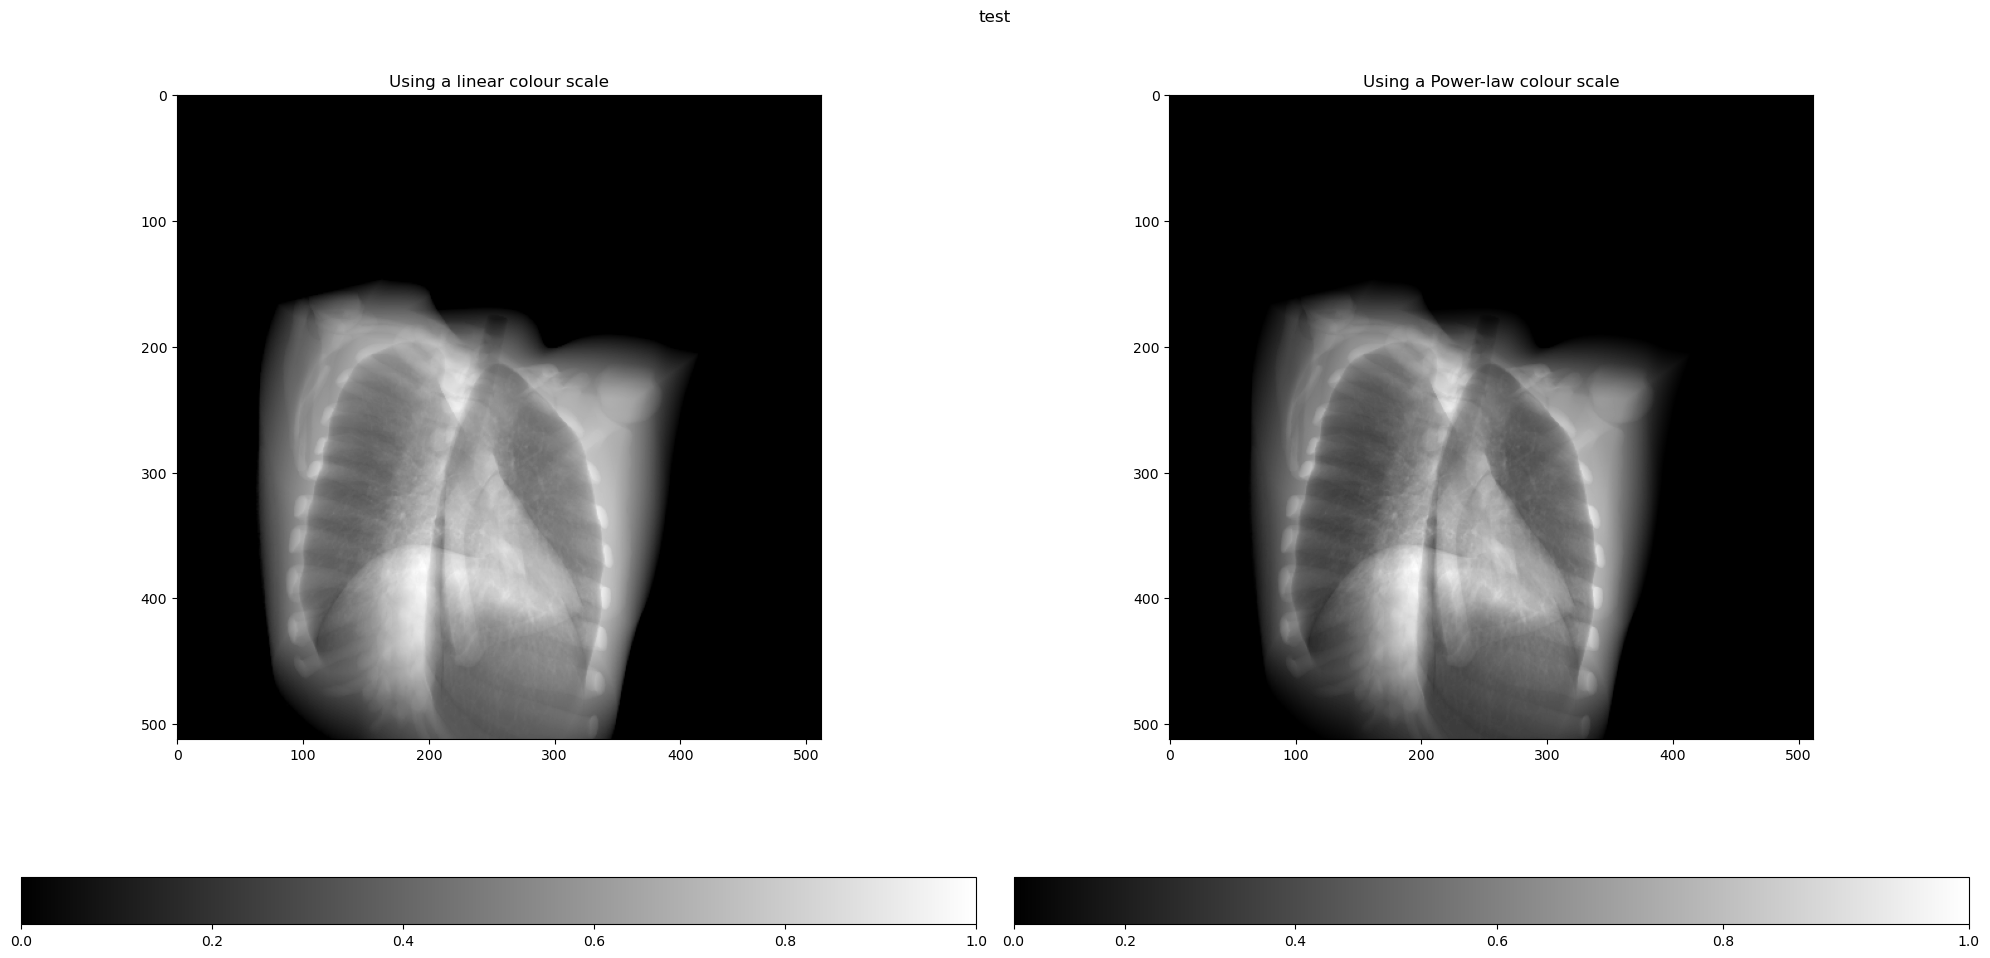

In [56]:
xray_image_rmse_cmaes  = applyLogScaleAndNegative(updateXRayImage(res_cmaes_X))
displayLinearPowerScales(xray_image_rmse_cmaes, "test", "test")

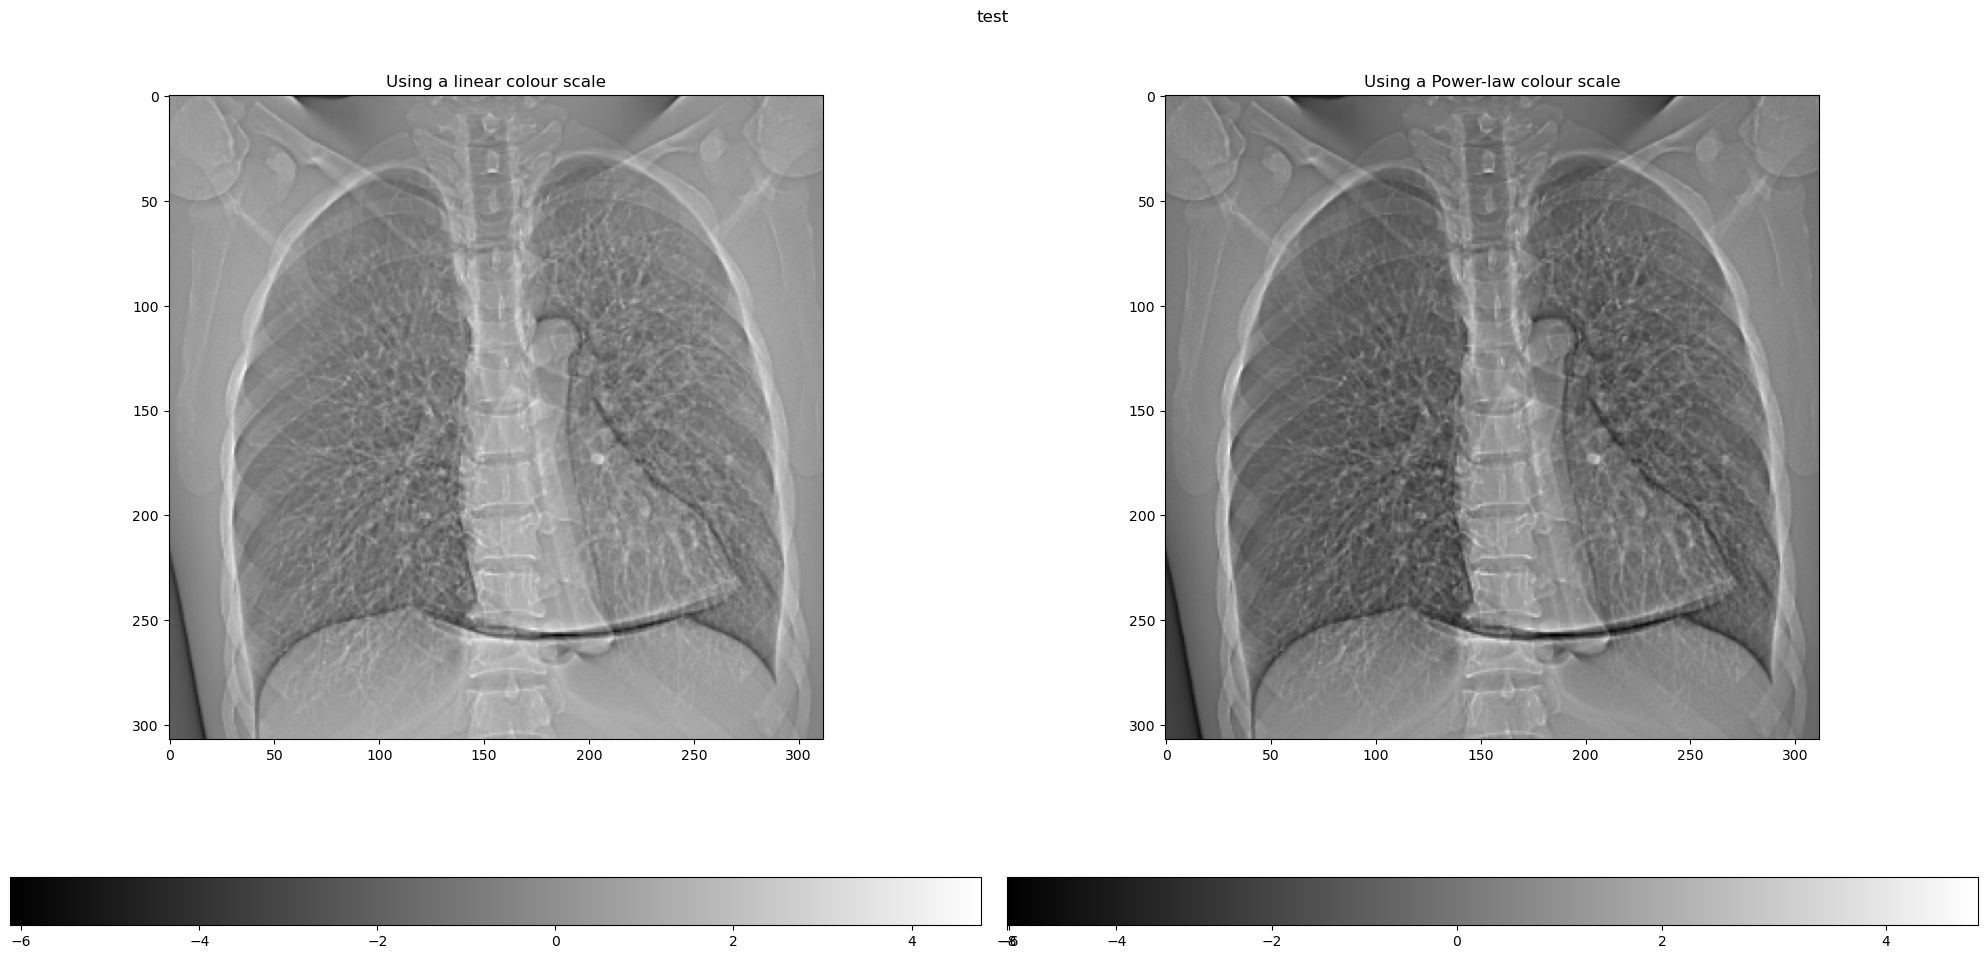

In [57]:
displayLinearPowerScales(standardised_roi_ground_truth, "test", "test")

In [58]:
fig = make_subplots(rows=1, cols=7,
                    start_cell="bottom-left",
                    subplot_titles=("Ground truth", "Best RMSE (NSGA-III)", "Best RMSE (CMA-ES)"))

standardised_ground_truth = standardisation(raw_reference_before_cropping)
rmse_img_set = [standardised_ground_truth,
                 #standardisation(xray_image_rmse_nsga3), 
                 standardisation(xray_image_rmse_cmaes)]

for n, image in enumerate(rmse_img_set):
    
    im = px.imshow(image, aspect="equal", binary_string=True, zmin=standardised_roi_ground_truth.min(), zmax=standardised_roi_ground_truth.max())
    fig.add_trace(im.data[0], 1, n + 1)

fig.update_xaxes(showticklabels=False) # hide all the xticks
fig.update_yaxes(showticklabels=False) # hide all the yticks
fig.update_layout(coloraxis_showscale=False)

fig.update_layout(
    font_family="Arial",
    font_color="black",
    title_font_family="Arial",
    title_font_color="black",
    legend_title_font_color="black"
)

fig.update_layout(
    height=300,
    width=800
)

fig.write_image(output_path + "/lungman-CMAES-objectives.pdf", engine="kaleido")
fig.write_image(output_path + "/lungman-CMAES-objectives.png", engine="kaleido")

fig.show()

In [ ]:
# Apply the transformation
xray_image_rmse_cmaes = applyLogScaleAndNegative(updateXRayImage(res_cmaes_X, restore_transformation=False));

In [ ]:
standardised_corrected_xray_image = standardisation(xray_image_rmse_cmaes[y_min_id:y_max_id, x_min_id:x_max_id])

imwrite(output_path + "/standardised_corrected_xray_image.tif", standardised_corrected_xray_image.astype(np.single))
hist_ref = np.histogram(standardised_roi_ground_truth, 100)[0]

standardised_roi_ground_truth = standardised_roi_ground_truth.astype(np.single)
gX = cv2.Sobel(standardised_roi_ground_truth, ddepth=cv2.CV_32F, dx=1, dy=0)
gY = cv2.Sobel(standardised_roi_ground_truth, ddepth=cv2.CV_32F, dx=0, dy=1)
gX = cv2.convertScaleAbs(gX)
gY = cv2.convertScaleAbs(gY)
ref_grad_magn = cv2.addWeighted(gX, 0.5, gY, 0.5, 0)

hist_ref = np.histogram(ref_grad_magn, 100)[0]

In [ ]:
gvxr.displayScene()
gvxr.useNegative()

gvxr.setZoom(1339.6787109375)
gvxr.setSceneRotationMatrix([0.8227577805519104, 0.1368587613105774, -0.5516625642776489, 0.0, -0.5680444240570068, 0.23148967325687408, -0.7897683382034302, 0.0, 0.01961756870150566, 0.9631487131118774, 0.26820749044418335, 0.0, 0.0, 0.0, 0.0, 1.0])

gvxr.setWindowBackGroundColour(0.5, 0.5, 0.5)

gvxr.displayScene()

In [ ]:
# gvxr.renderLoop()

In [ ]:
# print(gvxr.getZoom())
# print(gvxr.getSceneRotationMatrix())

In [ ]:
screenshot = (255 * np.array(gvxr.takeScreenshot())).astype(np.uint8)

In [ ]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig(output_path + '/lungman-optimised-screenshot-beam-on.pdf')
plt.savefig(output_path + '/lungman-optimised-screenshot-beam-on.png')

In [ ]:
fullCompareImages(standardised_roi_ground_truth,
                  standardised_corrected_xray_image,
                  "gVirtualXRay",
                  # output_path + "/lungman-projection-rmse-cmaes", vmin=standardised_roi_ground_truth.min(), vmax=standardised_roi_ground_truth.max(),
                  output_path + "/lungman-projection-rmse-cmaes", detector_element_spacing, vmin=-1.5, vmax=1.5)

In [ ]:
ref_diag = np.diag(standardised_roi_ground_truth)
test_diag = np.diag(standardised_corrected_xray_image)

plt.figure(figsize=(15, 7))

ax = plt.subplot(111)

ax.set_title("Diagonal profiles")

ax.plot(ref_diag, label="Projection from ")
ax.plot(test_diag, label="gVirtualXRay (without post-processing)")

ax.legend(loc='best',
          ncol=1, fancybox=True, shadow=True)

# plt.legend()

plt.savefig(output_path + '/lungman-profiles-projection-rmse-cmaes.pdf')
plt.savefig(output_path + '/lungman-profiles-projection-rmse-cmaes.png')

# Compute the magnification

$magnification = \frac{SID}{SOD}$ with $SID$ the source to imager distance and $SOD$ the source to object distance.

In [ ]:
source_position = gvxr.getSourcePosition("mm")
detector_position = gvxr.getDetectorPosition("mm")

object_bbox = gvxr.getNodeAndChildrenBoundingBox("root", "mm")
object_position = [(object_bbox[0] + object_bbox[3]) / 2,
                   (object_bbox[1] + object_bbox[4]) / 2,
                   (object_bbox[2] + object_bbox[5]) / 2
                  ]

source_imager_distance = distance.euclidean(source_position, detector_position)
source_object_distance = distance.euclidean(source_position, object_position)

magnification = source_imager_distance / source_object_distance

In [ ]:
print("SID:", source_imager_distance, "mm")
print("SOD:", source_object_distance, "mm")
print("magnification:", magnification)

# Compute the pixel size in the object plane

In [ ]:
spacing = source_imager_distance * detector_element_spacing / source_object_distance

print("spacing in the object plane (in mm):", spacing)

# Post-processing using image sharpening

We can see from the real image that an image sharpening filter was applied. We will implement one and optimise its parameters.

In [ ]:
def sharpen(image, ksize, shift, scale):
    details = image - gaussian(image, ksize)    

    return (details + shift) * scale

## Define an objective function

In [ ]:
# Compute the X-ray image
xray_image = np.flip(gvxr.computeXRayImage())

# Flat-field
xray_image_flat = xray_image[y_min_id:y_max_id, x_min_id:x_max_id] / total_energy_in_MeV

In [ ]:
def objectiveFunctionSharpen(x):
    
    global xray_image_flat
    global standardised_roi_ground_truth

    objectives = []

    for parameters in x:

        # Retrieve the parameters
        shift1, scale1, sigma1, sigma2, shift2, scale2 = parameters

        # Process the image
        contrast = (xray_image_flat + shift1) * scale1
        details = sharpen(xray_image_flat, (sigma1, sigma2), shift2, scale2)
        sharpened = contrast + details
        sharpened[sharpened < 1e-9] = 1e-9
        log_image = np.log(contrast + details)
        negative = log_image * -1
        normalised = standardisation(negative)

        # Return the objective
        objective = math.sqrt(mean_squared_error(standardised_roi_ground_truth, normalised))
        # objective = math.sqrt(mean_squared_error(ref_grad_magn, test_grad_magn))
        # objective = math.sqrt(mean_squared_error(hist_ref, hist_test))

        # objective = ref_grad_magn.sum() - test_grad_magn.sum()
        # objective *= objective
        # objective *= -1

        # mi = normalized_mutual_info_score(hist_ref, hist_test)
        # dmi = (1.0 - mi) / 2.0
        # objective = dmi
        objectives.append(objective)
    
    return objectives

## Minimise the objective function

In [ ]:
sigma1 = 2
sigma2 = 2
alpha = 10.5
shift = 0
scale = 1

xl = [0, 0, 0, -5, 0]
xu = [10, 10, 15, 5, 2]
x_init = [sigma1, sigma2, alpha, shift, scale]

#0.003937458431052107 4012.600582499311 3.916470602237863 0.28374201341640476 6.851503972136956 6.8658686847669045e-09

xl = [0, 1e-9, 1, 1, 0, 0.5]
xu = [10000, 10000, 10, 10, 10000, 10000]
x_init = [0, 1, 3, 3, 0, 1]

In [ ]:
class SingleObjectiveProblem(Problem):

    def __init__(self):
        super().__init__(n_var=len(x_init), n_obj=1, n_constr=0, n_ieq_constr=0, xl=xl, xu=xu, vtype=float)
        # super().__init__(n_var=len(x_init), n_obj=1, n_constr=0, n_ieq_constr=0, vtype=float)

    def _evaluate(self, x, out, *args, **kwargs):

        out["F"] = np.array(objectiveFunctionSharpen(x))
        out["F"].shape = [len(x), 1]        

In [ ]:
# The registration has already been performed. Load the results.
if os.path.isfile(output_path + "/lungman_postprocess.dat"):

    shift1, scale1, sigma1, sigma2, shift2, scale2 = np.loadtxt(output_path + "/lungman_postprocess.dat")

else:
    # Optimise
    # timeout_in_sec = 20 * 60 # 20 minutes
    # opts = cma.CMAOptions()
    # opts.set('tolfun', 1e-10)
    # opts['tolx'] = 1e-10
    # opts['timeout'] = timeout_in_sec
    # opts['bounds'] = [xl, xu]
    # opts['CMA_stds'] = []

    # for min_val, max_val in zip(opts['bounds'][0], opts['bounds'][1]):
    #     opts['CMA_stds'].append(abs(max_val - min_val) * 0.05)

    problem = SingleObjectiveProblem()
    x0 = denormalize(np.random.random(problem.n_var), problem.xl, problem.xu)

    algorithm = CMAES(x0=x0,
                     sigma=0.5,
                     restarts=2,
                     maxfevals=np.inf,
                     tolfun=1e-6,
                     tolx=1e-6,
                     restart_from_best=True,
                     bipop=True)

    res = minimize(problem,
                   algorithm,
                   ('n_iter', 100),
                   seed=1,
                   save_history=True,
                   verbose=True)


    # # Optimise    
    # res = minimize(problem,
    #            algorithm,
    #            ('n_iter', 100),
    #            # seed=1,
    #            save_history=False,
    #            verbose=True)

    print(f"Best solution found: \nX = {res.X}\nF = {res.F}\nCV= {res.CV}")

    # Save the parameters
    shift1, scale1, sigma1, sigma2, shift2, scale2 = res.X
    np.savetxt(output_path + "/lungman_postprocess.dat", [shift1, scale1, sigma1, sigma2, shift2, scale2], header='shift1, scale1, sigma1, sigma2, shift2, scale2')

## Apply the result of the optimisation

In [ ]:
print(shift1, scale1, sigma1, sigma2, shift2, scale2) #    return scale * (shift + image) + alpha * details

# Process the image
contrast = (xray_image_flat + shift1) * scale1
details = sharpen(xray_image_flat, (sigma1, sigma2), shift2, scale2)
sharpened = contrast + details
sharpened[sharpened < 1e-9] = 1e-9
log_image = np.log(contrast + details)
negative = log_image * -1
normalised = standardisation(negative)

In [ ]:
font = {'size'   : 12.5
       }
matplotlib.rc('font', **font)

In [ ]:
new_image_without_post_process = standardised_corrected_xray_image * raw_reference.std()
new_image_without_post_process -= standardised_corrected_xray_image.mean()
new_image_without_post_process += raw_reference.mean()

new_image_with_post_process = normalised * raw_reference.std()
new_image_with_post_process -= normalised.mean()
new_image_with_post_process += raw_reference.mean()

In [ ]:
old_zncc = np.mean(standardised_roi_ground_truth * standardised_corrected_xray_image)
new_zncc = np.mean(standardised_roi_ground_truth * normalised)

In [ ]:
old_mape = mape(raw_reference, new_image_without_post_process)
new_mape = mape(raw_reference, new_image_with_post_process)

In [ ]:
old_ssim = ssim(raw_reference, new_image_without_post_process, data_range=raw_reference.max() - raw_reference.min())
new_ssim = ssim(raw_reference, new_image_with_post_process, data_range=raw_reference.max() - raw_reference.min())

In [ ]:
print("ZNCC before sharpening:", str(100 * old_zncc) + "%")
print("ZNCC after sharpening:", str(100 * new_zncc) + "%")

print("MAPE before sharpening:", str(100 * old_mape) + "%")
print("MAPE after sharpening:", str(100 * new_mape) + "%")

print("SSIM before sharpening:", str(old_ssim))
print("SSIM after sharpening:", str(new_ssim))

In [ ]:
ground_truth_diag = np.diag(raw_reference)
gvxr_diag = np.diag(new_image_with_post_process)

print(ground_truth_diag.shape)
x = np.linspace(0, ground_truth_diag.shape[0], ground_truth_diag.shape[0]) * spacing[0]
plt.figure(figsize=(15, 5))

ax = plt.subplot(111)

ax.set_title("Diagonal profiles")

ax.plot(x, ground_truth_diag, label="Ground truth (Digital Radiography)")
ax.plot(x, gvxr_diag, label="gVirtualXRay")

ax.legend(loc='best',
          ncol=1, fancybox=True, shadow=True)

plt.xlabel("Pixel position (in mm)")
plt.ylabel("Pixel intensity")

plt.savefig(output_path + '/lungman-profiles-projection-postprocessing.pdf')
plt.savefig(output_path + '/lungman-profiles-projection-postprocessing.png')

In [ ]:
window_centre = int(volume.GetMetaData("0028|1050").split("\\")[1]) # Use 0 for normal, 1 for harder, 2 for softer
window_width = int(volume.GetMetaData("0028|1051").split("\\")[1]) # Use 0 for normal, 1 for harder, 2 for softer

print("Window Center used: ", window_centre)
print("Window Width used: ", window_width)

vmin = window_centre - window_width / 2
vmax = window_centre + window_width / 2

view_position = volume.GetMetaData("0018|5101")

In [ ]:
fullCompareImages(raw_reference,
                  new_image_with_post_process,
                  "gVirtualXRay",
                  output_path + "/lungman-projection-harder", spacing, log=False, vmin=vmin, vmax=vmax)

In [ ]:
plt.figure(figsize= (20,10))
xrange=range(raw_reference.shape[1])
yrange=range(raw_reference.shape[0])

plt.xlabel("Pixel position\n(in mm)")
plt.ylabel("Pixel position\n(in mm)")
plt.title(view_position + " projection\nkVp:" + str(kVp))
plt.imshow(raw_reference, cmap="gray", 
           vmin=vmin, vmax=vmax,
           extent=[0,(raw_reference.shape[1]-1)*spacing[0],0,(raw_reference.shape[0]-1)*spacing[1]])
plt.colorbar(orientation='vertical')

plt.savefig(output_path + '/lungman_experimental_DX_image-harder.pdf')
plt.savefig(output_path + '/lungman_experimental_DX_image-harder.png')

In [ ]:
plt.figure(figsize= (20,10))
xrange=range(raw_reference.shape[1])
yrange=range(raw_reference.shape[0])

plt.xlabel("Pixel position\n(in mm)")
plt.ylabel("Pixel position\n(in mm)")
plt.title(view_position + " projection\nkVp:" + str(kVp))
plt.imshow(new_image_with_post_process, cmap="gray", 
           vmin=vmin, vmax=vmax,
           extent=[0,(raw_reference.shape[1]-1)*spacing[0],0,(raw_reference.shape[0]-1)*spacing[1]])
plt.colorbar(orientation='vertical')

plt.savefig(output_path + '/lungman_simulated_DX_image-harder.pdf')
plt.savefig(output_path + '/lungman_simulated_DX_image-harder.png')

In [ ]:
runtimes = []

resetToDefaultParameters()
setTransformations(res_nsga3_X[best_dzncc_id])

for i in range(25):
    start_time = datetime.datetime.now()

    raw_x_ray_image = np.array(gvxr.computeXRayImage())

    # Process the image
    xray_image_flat = raw_x_ray_image / total_energy_in_MeV
    contrast = (xray_image_flat + shift1) * scale1
    details = sharpen(xray_image_flat, (sigma1, sigma2), shift2, scale2)
    sharpened = contrast + details
    sharpened[sharpened < 1e-9] = 1e-9
    log_image = np.log(contrast + details)
    negative = log_image * -1
    
    end_time = datetime.datetime.now()
    delta_time = end_time - start_time
    runtimes.append(delta_time.total_seconds() * 1000)

In [ ]:
runtime_avg = round(np.mean(runtimes))
runtime_std = round(np.std(runtimes))

raw_x_ray_image = np.array(raw_x_ray_image)

In [ ]:
ZNCC = df_nsga3["ZNCC"].max()
SSIM = df_nsga3["SSIM"].max()
MAPE = df_nsga3["MAPE"].max()

print("Lungman PA view & Real digital radiograph  & " + 
      "{0:0.2f}".format(100 * new_mape) + "\\%    &    " +
      "{0:0.2f}".format(100 * new_zncc) + "\\%    &    " +
      "{0:0.2f}".format(new_ssim) + "    &    $" +
      str(raw_x_ray_image.shape[1]) + " \\times " + str(raw_x_ray_image.shape[0]) + "$    &    N/A   &" +
      str(number_of_triangles) + "    &    " +
      "$" + str(runtime_avg) + " \\pm " + str(runtime_std) + "$  & N/A \\\\")

# Visualise the virtual patient

In [ ]:
plot = visualise(use_log=True, use_negative=True, sharpen_ksize=2, sharpen_alpha=1.0)
plot.background_color = 0xffffff

In [ ]:
fname = output_path + '/lungman_model.png'
if not os.path.isfile(fname):

    plot.fetch_screenshot() # Not sure why, but we need to do it twice to get the right screenshot
    
    data = base64.b64decode(plot.screenshot)
    with open(fname,'wb') as fp:
        fp.write(data)

## All done

Destroy the window

In [ ]:
gvxr.destroyAllWindows()